# Datenprofil – Missingness & Korrelationen
Kurz & praktisch: lädt `features.csv` (mit NAs) + `target.csv`, analysiert Missing-Pattern, Visuals, und Heatmaps für (Erwartungs‑)Fragen vs. IP‑Änderung.

In [59]:
import pandas as pd, numpy as np, glob, pathlib, re

# --- Parser Hilfsfunktionen ---
def _to_month_start(ts):
    if pd.isna(ts): return pd.NaT
    ts = pd.Timestamp(ts)
    return pd.Timestamp(ts.year, ts.month, 1)

DOT_DDMMYY = re.compile(r'^\s*\d{2}\.\d{2}\.(\d{2}|\d{4})\s*$')

def parse_month(x):
    if pd.isna(x): return pd.NaT
    if isinstance(x, (int, float)) and not np.isnan(x):
        return _to_month_start(pd.to_datetime(x, unit='d', origin='1899-12-30', errors='coerce'))
    s = str(x).strip()
    if DOT_DDMMYY.fullmatch(s):
        return _to_month_start(pd.to_datetime(s, dayfirst=True, errors='coerce'))
    if re.fullmatch(r"\d{2}[./]\d{4}", s):
        return _to_month_start(pd.to_datetime(s.replace(".", "/"), format="%m/%Y", errors="coerce"))
    if re.fullmatch(r"\d{4}[./]\d{2}", s):
        y, m = re.split(r"[./]", s); return pd.Timestamp(int(y), int(m), 1)
    if re.fullmatch(r"\d{4}", s):
        return pd.Timestamp(int(s), 1, 1)
    dt = pd.to_datetime(s, errors="coerce", dayfirst=True)
    return _to_month_start(dt) if pd.notna(dt) else pd.NaT

def missing_pattern_report(df: pd.DataFrame):
    lead_flags, trail_flags, mid_flags, any_flags, only_flags = [], [], [], [], []

    for c in df.columns:
        a = df[c].isna().to_numpy()

        if not a.any():
            lead_flags.append(False)
            trail_flags.append(False)
            mid_flags.append(False)
            any_flags.append(False)
            only_flags.append(False)
            continue

        if a.all():
            only_flags.append(True)
        else:
            only_flags.append(False)

        lead = 0
        for v in a:
            if v: lead += 1
            else: break

        trail = 0
        for v in a[::-1]:
            if v: trail += 1
            else: break

        mid = a[lead:len(a)-trail].any() if (lead+trail) < len(a) else False

        lead_flags.append(lead > 0)
        trail_flags.append(trail > 0)
        mid_flags.append(mid)
        any_flags.append(True)

    lead_flags = np.array(lead_flags)
    trail_flags = np.array(trail_flags)
    mid_flags = np.array(mid_flags)
    any_flags = np.array(any_flags)
    only_flags = np.array(only_flags)

    return {
        "completely_NA": int(np.sum(only_flags)),
        "leading_only": int(np.sum(lead_flags & ~trail_flags & ~mid_flags & ~only_flags)),
        "trailing_only": int(np.sum(trail_flags & ~lead_flags & ~mid_flags & ~only_flags)),
        "mid_only": int(np.sum(mid_flags & ~lead_flags & ~trail_flags & ~only_flags)),
        "leading_and_trailing": int(np.sum(lead_flags & trail_flags & ~mid_flags & ~only_flags)),
        "leading_and_mid": int(np.sum(lead_flags & mid_flags & ~trail_flags & ~only_flags)),
        "trailing_and_mid": int(np.sum(trail_flags & mid_flags & ~lead_flags & ~only_flags)),
        "leading_trailing_mid": int(np.sum(lead_flags & trail_flags & mid_flags & ~only_flags)),
        "any_NA": int(np.sum(any_flags)),
    }


# --- Dateien einlesen und zusammenbauen ---
DATA_DIR = pathlib.Path("../../data/raw/features")
files = sorted(map(pathlib.Path, glob.glob(str(DATA_DIR / "bdi1a_*.xlsx"))))
if not files:
    raise FileNotFoundError("keine bdi1a_*.xlsx gefunden")

long_frames = []
for p in files:
    df = pd.read_excel(p, skiprows=2, engine="openpyxl")
    date_col = df.columns[0]
    df = df.rename(columns={date_col: "date"})
    df["date"] = df["date"].map(parse_month)
    long_frames.append(df.melt(id_vars="date", var_name="title_raw", value_name="value"))

panel_long = pd.concat(long_frames, ignore_index=True).dropna(subset=["date"])

# --- Wide Pivot mit allen Spalten behalten ---
full_df = panel_long.pivot_table(
    index="date", columns="title_raw", values="value", aggfunc="last", dropna=False
)
full_df.index = pd.to_datetime(full_df.index, errors="coerce").to_period("M").to_timestamp()
full_df = full_df[~full_df.index.duplicated(keep="last")]

print("Full merged shape:", full_df.shape)

# --- Analyse ---
report = missing_pattern_report(full_df)
print("Missingness report (Spalten):")
for k, v in report.items():
    print(f"{k}: {v}")


Full merged shape: (410, 2655)
Missingness report (Spalten):
completely_NA: 1
leading_only: 435
trailing_only: 49
mid_only: 0
leading_and_trailing: 10
leading_and_mid: 0
trailing_and_mid: 0
leading_trailing_mid: 0
any_NA: 495


In [60]:

# CHUNK 0 — Pfade & Settings
features_file = "../../data/processed/features.csv"  # alle Features inkl. Missing
target_file   = "../../data/processed/target.csv"  # IP (Level + Änderung?)

# optional: Branchen‑Whitelist (leer = alle)
industry_whitelist = [
    # "Verarbeitendes_Gewerbe",
    # "Herstellung_von_Investitionsgütern",
]

# param: Rolling für Dot‑Plot (IP‑Änderung)
rm_window = 12  # Monate


## Test Stationarity, Mean & Var

In [61]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Daten laden
df = pd.read_csv(target_file, parse_dates=["date"])
mom = df["IP_change"].dropna()
print("Mean:", mom.mean())
print("Varianz:", mom.var())
# ADF-Test Funktion
def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f"--- {title} ---")
    print("ADF-Statistik:", result[0])
    print("p-Wert:", result[1])
    for key, value in result[4].items():
        print(f"kritischer Wert {key}: {value}")
    print()

# Tests
adf_test(df["IP"], "IP (Level)")
adf_test(df["IP_change"], "IP_change (MoM)")
adf_test(df["IP_yoy"], "IP_yoy (YoY)")


Mean: 0.04274140564293427
Varianz: 3.630184878853925
--- IP (Level) ---
ADF-Statistik: -1.6044180366906216
p-Wert: 0.481373795486562
kritischer Wert 1%: -3.446599953548936
kritischer Wert 5%: -2.86870295908671
kritischer Wert 10%: -2.570585643956714

--- IP_change (MoM) ---
ADF-Statistik: -17.205325106153715
p-Wert: 6.420299971246067e-30
kritischer Wert 1%: -3.446599953548936
kritischer Wert 5%: -2.86870295908671
kritischer Wert 10%: -2.570585643956714

--- IP_yoy (YoY) ---
ADF-Statistik: -4.955405065341206
p-Wert: 2.7174141954025406e-05
kritischer Wert 1%: -3.4477686860685
kritischer Wert 5%: -2.869216670067509
kritischer Wert 10%: -2.570859500573892



In [62]:
import re

# Kanon der ~13 Frage-Typen (normalized); hier gern ergänzen/ändern:
QUESTION_CANON = [
    "auftragsbestand_beurteilung",
    "auftragsbestand_beurteilung_export",
    "auftragsbestand_gegen_vormonat",
    "beschaeftigtenerwartungen",       # ä->ae
    "exporterwartungen",
    "fertigwarenlager_beurteilung",
    "geschaeftsklima",                  # ä->ae
    "geschaeftslage_beurteilung",
    "geschaeftslage_erwartungen",
    "nachfrage_gegen_vormonat",
    "preise_gegen_vormonat",
    "preiserwartungen",
    "produktion_gegen_vormonat",
    "produktionsplaene",                # ä->ae
    "produktivitaetserwartungen"        # ä->ae
]

def _slug(s: str) -> str:
    s = s.lower()
    # Umlaute -> ASCII, Leerzeichen/Minus -> _
    s = (s.replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss")
           .replace(" ", "_").replace("-", "_"))
    # nur a-z0-9_. behalten, doppelte Punkte/Underscores reduzieren
    s = re.sub(r"[^a-z0-9_\.]+", "", s)
    s = re.sub(r"\.+", ".", s)
    s = re.sub(r"_+", "_", s)
    return s.strip("._")

def split_norm(col: str):
    """
    Liefert (industry_norm, question_norm).
    Versucht zuerst, eine Frage aus QUESTION_CANON am Stringende zu matchen.
    Fallback: Split nach letztem '.'.
    Entfernt Rauschen wie führende Nummern ('1.'), 'n.g.' etc. vor der Frage.
    """
    s = _slug(col)
    # 1) Ende-gegen-Kanon
    for q in QUESTION_CANON:
        if s.endswith("." + q):
            ind = s[:-(len(q)+1)].strip("._")
            return ind, q
        if s.endswith(q):
            # nur akzeptieren, wenn davor ein '.' war
            before = s[:-(len(q))]
            if before.endswith("."):
                ind = before[:-1].strip("._")
                return ind, q
    # 2) Fallback: letzter Punkt
    if "." in s:
        ind, qraw = s.rsplit(".", 1)
        # Nummern-/NG-Präfix vor der Frage abwerfen
        q = re.sub(r"^(?:\d+\.|n\.?g\.?|ng\.?)+", "", qraw)
        q = q.strip("._")
        return ind.strip("._"), q
    return "", s


In [63]:
#  Daten laden
import pandas as pd, numpy as np

def _read_timeseries_csv(path):
    df = pd.read_csv(path)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
    else:
        df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
        df = df.set_index(df.columns[0])
    return df.sort_index()

# --- Bestehende Files ---
X_full = _read_timeseries_csv(features_file)
y_df   = _read_timeseries_csv(target_file)

# --- Neue Files ---
X_original = _read_timeseries_csv("../../data/processed/features.csv")
# Variante ohne führende/trailing NAs
X_original_NA_cutted = X_original.copy()
while X_original_NA_cutted.iloc[0].isna().any():
    X_original_NA_cutted = X_original_NA_cutted.iloc[1:]
while X_original_NA_cutted.iloc[-1].isna().any():
    X_original_NA_cutted = X_original_NA_cutted.iloc[:-1]

# Zielspalten
y_cols = list(y_df.columns)
if len(y_cols) >= 2:
    y_level  = y_df.iloc[:,0].astype(float)
    y_change = y_df.iloc[:,1].astype(float)
else:
    y_level  = y_df.iloc[:,0].astype(float)
    y_change = y_level.diff()

# optional branchen filtern
if industry_whitelist:
    wl = set(industry_whitelist)
    keep = [c for c in X_full.columns if c.split('.',1)[0] in wl]
    X_full = X_full[keep]
    X_original = X_original[keep]
    X_original_NA_cutted = X_original_NA_cutted[keep]
    print(f"gefilterte Spalten: {len(keep)}")

# gemeinsame Zeitachse
idx = X_full.index.intersection(y_df.index)
X_full = X_full.loc[idx]
y_level = y_level.loc[idx]
y_change = y_change.loc[idx]

print("X_full", X_full.shape, "y_change", y_change.shape)
print("X_original_NA_cutted", X_original_NA_cutted.shape)



X_full (408, 2654) y_change (408,)
X_original_NA_cutted (141, 2654)


In [40]:
import numpy as np

def missing_pattern_report(df: pd.DataFrame):
    # Flags pro Spalte
    lead_flags, trail_flags, mid_flags, any_flags = [], [], [], []

    for c in df.columns:
        a = df[c].isna().to_numpy()
        if not a.any():
            lead_flags.append(False)
            trail_flags.append(False)
            mid_flags.append(False)
            any_flags.append(False)
            continue

        # leading count
        lead = 0
        for v in a:
            if v: lead += 1
            else: break

        # trailing count
        trail = 0
        for v in a[::-1]:
            if v: trail += 1
            else: break

        # Mitte prüfen
        mid = a[lead:len(a)-trail].any() if (lead+trail) < len(a) else False

        lead_flags.append(lead > 0)
        trail_flags.append(trail > 0)
        mid_flags.append(mid)
        any_flags.append(True)

    lead_flags = np.array(lead_flags)
    trail_flags = np.array(trail_flags)
    mid_flags = np.array(mid_flags)
    any_flags = np.array(any_flags)

    report = {
        "leading_only": int(np.sum(lead_flags & ~trail_flags & ~mid_flags)),
        "trailing_only": int(np.sum(trail_flags & ~lead_flags & ~mid_flags)),
        "mid_only": int(np.sum(mid_flags & ~lead_flags & ~trail_flags)),
        "leading_and_trailing": int(np.sum(lead_flags & trail_flags & ~mid_flags)),
        "leading_and_mid": int(np.sum(lead_flags & mid_flags & ~trail_flags)),
        "trailing_and_mid": int(np.sum(trail_flags & mid_flags & ~lead_flags)),
        "leading_trailing_mid": int(np.sum(lead_flags & trail_flags & mid_flags)),
        "any_NA": int(np.sum(any_flags)),
    }
    return report

# Anwenden
report = missing_pattern_report(X_full)
for k,v in report.items():
    print(f"{k}: {v}")



leading_only: 436
trailing_only: 48
mid_only: 0
leading_and_trailing: 9
leading_and_mid: 0
trailing_and_mid: 0
leading_trailing_mid: 0
any_NA: 493


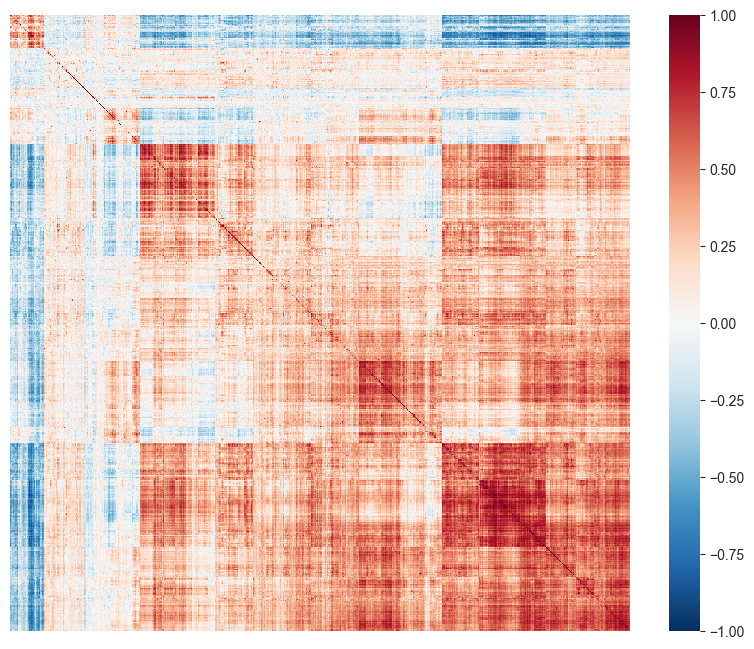

Stärkste positive Korrelation: (('Verarbeitendes_Gewerbe_(ohne_Ernährungsgewerbe).Auftragsbestand_Beurteilung', 'Verarbeitendes_Gewerbe.Auftragsbestand_Beurteilung'), 0.9995307080368514)
Stärkste negative Korrelation: (('Verarbeitendes_Gewerbe_(ohne_Ernährungsgewerbe).Fertigwarenlager_Beurteilung', 'Herstellung_von_Vorleistungsgütern.Auftragsbestand_Beurteilung'), -0.9424359564372995)
Anzahl Korrelationen > 0.9: 46
Anzahl Korrelationen < -0.9: 36


In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
import numpy as np

# --- Cluster-Sortierte Heatmap ---
corr = X_full.corr()

linkage_matrix = linkage(corr, method="ward")
ordered_idx = leaves_list(linkage_matrix)
corr_sorted = corr.iloc[ordered_idx, ordered_idx]

plt.figure(figsize=(10,8))
sns.heatmap(
    corr_sorted,
    cmap="RdBu_r",      # kontrastreicher als coolwarm
    center=0,           # 0 = neutral (weiß)
    vmin=-1, vmax=1,    # Skala auf -1...1 fixiert
    cbar=True,
    xticklabels=False,
    yticklabels=False
)
plt.axis("off")
plt.show()


# --- Größte & kleinste Korrelation ---
mask = np.tril(np.ones(corr.shape, dtype=bool))  # unteres Dreieck inkl. Diagonale
corr_unstacked = corr.where(~mask).unstack().dropna()

max_pair = corr_unstacked.idxmax(), corr_unstacked.max()
min_pair = corr_unstacked.idxmin(), corr_unstacked.min()

print("Stärkste positive Korrelation:", max_pair)
print("Stärkste negative Korrelation:", min_pair)

# --- Zählen von starken Korrelationen ---
high_pos = (corr_unstacked > 0.99).sum()
high_neg = (corr_unstacked < -0.9).sum()

print(f"Anzahl Korrelationen > 0.9: {high_pos}")
print(f"Anzahl Korrelationen < -0.9: {high_neg}")



Saved to: ../grafiken/correlation_distribution.png


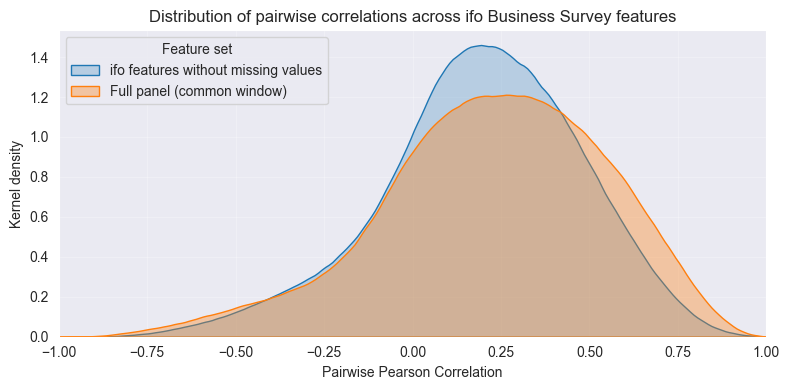

In [82]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Output folder
os.makedirs("../grafiken", exist_ok=True)

# --- Pairwise correlations ---
corr_full = X_full.corr()
corr_cut  = X_original_NA_cutted.corr()

# Flatten upper triangle (excluding diagonal)
mask = np.tril(np.ones(corr_full.shape, dtype=bool))
vals_full = corr_full.where(~mask).stack().values
vals_cut  = corr_cut.where(~mask).stack().values

plt.figure(figsize=(8, 4))

sns.kdeplot(
    vals_full,
    fill=True,
    bw_adjust=0.6,
    label="ifo features without missing values"
)
sns.kdeplot(
    vals_cut,
    fill=True,
    bw_adjust=0.6,
    alpha=0.35,
    label="Full panel (common window)"
)

plt.xlim(-1, 1)
plt.xlabel("Pairwise Pearson Correlation")
plt.ylabel("Kernel density")
plt.title("Distribution of pairwise correlations across ifo Business Survey features")
plt.legend(frameon=True, title="Feature set")
plt.grid(True, alpha=0.25)
plt.tight_layout()

# --- Save ---
save_path = os.path.join("../grafiken", "correlation_distribution.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"Saved to: {save_path}")

plt.show()


In [66]:
# CHUNK 2 — Missing-Pattern je Spalte
import numpy as np, pandas as pd

def missing_pattern_flags(s: pd.Series):
    a = s.isna().to_numpy()
    if not a.any():
        return False, False, False, False  # has, lead, mid, trail
    # leading
    lead = 0
    for v in a:
        if v: lead += 1
        else: break
    # trailing
    trail = 0
    for v in a[::-1]:
        if v: trail += 1
        else: break
    has = True
    # mid
    if lead + trail >= len(a):
        mid = False  # alles NaN oder nur lead/trail
    else:
        mid = a[lead:len(a)-trail].any()
    return has, (lead>0), mid, (trail>0)

flags = np.array([missing_pattern_flags(X_full[c]) for c in X_full.columns], dtype=bool)
if flags.size == 0:
    raise ValueError("Keine Spalten in X_full.")

has_miss = flags[:,0]
lead = flags[:,1]
mid  = flags[:,2]
trail= flags[:,3]

n = X_full.shape[1]
pct = lambda k: 100.0 * k / n

print(f"% mit mind. 1 Missing: {pct(has_miss.sum()):.1f}")
print(f"% Anfang fehlt:       {pct(lead.sum()):.1f}")
print(f"% Mitte fehlt:        {pct(mid.sum()):.1f}")
print(f"% Ende fehlt:         {pct(trail.sum()):.1f}")
print("-- Kombis --")
print(f"% Anfang & Ende:      {pct((lead & trail).sum()):.1f}")
print(f"% Anfang & Mitte:     {pct((lead & mid).sum()):.1f}")
print(f"% Ende & Mitte:       {pct((trail & mid).sum()):.1f}")


% mit mind. 1 Missing: 18.6
% Anfang fehlt:       16.8
% Mitte fehlt:        0.0
% Ende fehlt:         2.1
-- Kombis --
% Anfang & Ende:      0.3
% Anfang & Mitte:     0.0
% Ende & Mitte:       0.0


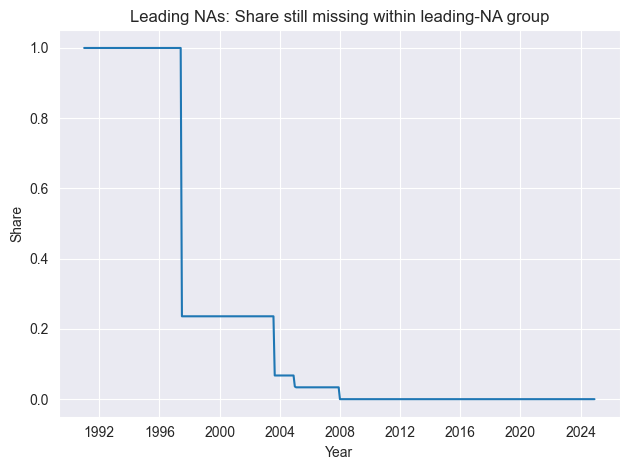

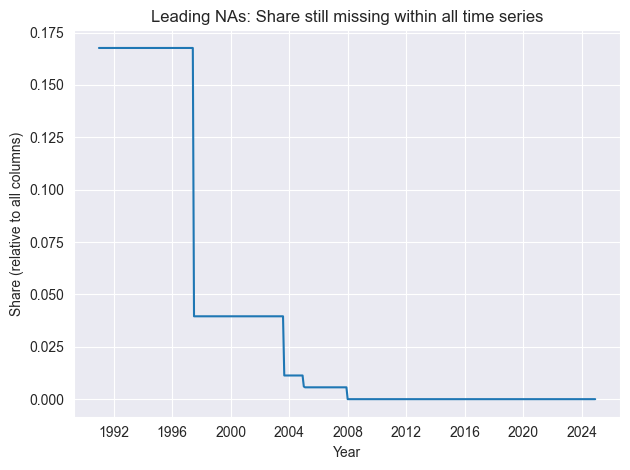

340 series start at 1997-07-01
75 series start at 2003-09-01
14 series start at 2005-01-01
1 series start at 2005-02-01
15 series start at 2008-01-01


In [67]:
# CHUNK 3 — Evolution: Share of still missing values (only leading NAs) absolute/relative
import numpy as np, matplotlib.pyplot as plt

lead_cols = [c for c, l in zip(X_full.columns, lead) if l]
if len(lead_cols) == 0:
    print("no columns with leading NAs")
else:
    fvi = {}
    arr_index = np.arange(len(X_full.index))
    for c in lead_cols:
        a = X_full[c].isna().to_numpy()
        # first valid = first False after leading True values
        lv = 0
        for v in a:
            if v:
                lv += 1
            else:
                break
        fvi[c] = lv  # number of leading NAs

    fvi_vals = np.array(list(fvi.values()))
    # absolute: share within the leading-NA group
    abs_curve = []
    for t in arr_index:
        still_missing = (fvi_vals > t).sum()
        abs_curve.append(still_missing / len(lead_cols))

    # relative: share relative to all columns
    rel_curve = []
    denom = X_full.shape[1]
    for t in arr_index:
        still_missing = (fvi_vals > t).sum()
        rel_curve.append(still_missing / denom)

    # Plot 1: absolute
    plt.figure()
    plt.plot(X_full.index, abs_curve)
    plt.xlabel("Year")
    plt.ylabel("Share")
    plt.title("Leading NAs: Share still missing within leading-NA group")
    plt.tight_layout()
    plt.show()

    # Plot 2: relative
    plt.figure()
    plt.plot(X_full.index, rel_curve)
    plt.xlabel("Year")
    plt.ylabel("Share (relative to all columns)")
    plt.title("Leading NAs: Share still missing within all time series")
    plt.tight_layout()
    plt.show()

# Compute jump points
jump_counts = pd.Series(fvi_vals).value_counts().sort_index()
for pos, count in jump_counts.items():
    print(f"{count} series start at {X_full.index[pos].date()}")



Gespeichert unter: ../grafiken/missing_rate_per_question.png


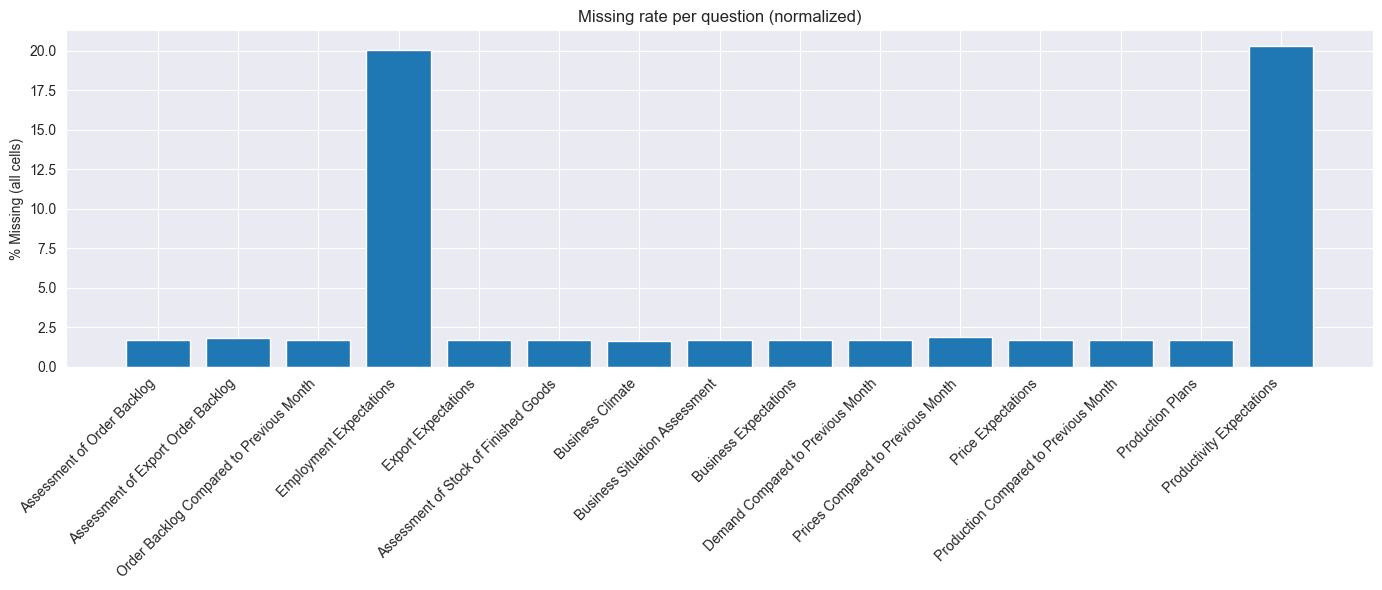

Gespeichert unter: ../grafiken/leading_NA_share_per_question.png


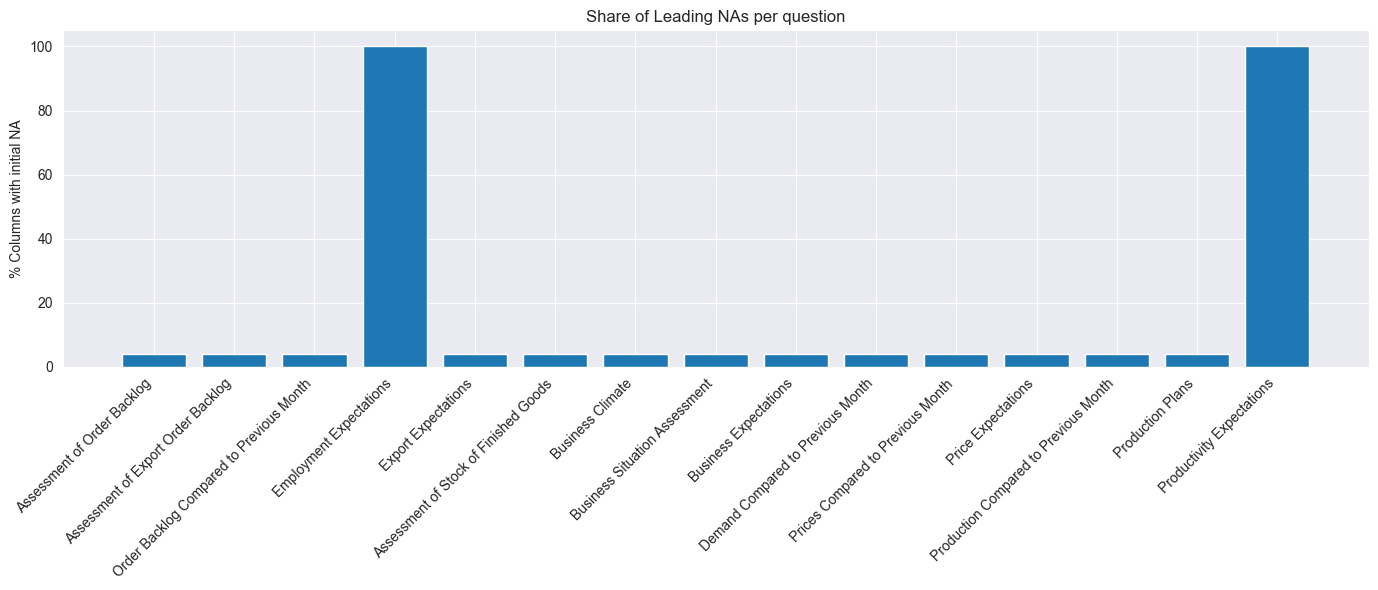

In [70]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sicherstellen, dass der Ausgabeordner existiert
os.makedirs("../grafiken", exist_ok=True)

mapping = {
    "geschaeftsklima": "Business Climate",
    "geschaeftslage_beurteilung": "Business Situation Assessment",
    "geschaeftslage_erwartungen": "Business Expectations",
    "beschaeftigungserwartung": "Employment Expectations",
    "fertigwarenlager_beurteilung": "Assessment of Stock of Finished Goods",
    "auftragsbestand_beurteilung": "Assessment of Order Backlog",
    "auftragsbestand_beurteilung_export": "Assessment of Export Order Backlog",
    "nachfrage_gegen_vormonat": "Demand Compared to Previous Month",
    "auftragsbestand_gegen_vormonat": "Order Backlog Compared to Previous Month",
    "produktion_gegen_vormonat": "Production Compared to Previous Month",
    "preise_gegen_vormonat": "Prices Compared to Previous Month",
    "produktionsplaene": "Production Plans",
    "preiserwartungen": "Price Expectations",
    "exporterwartungen": "Export Expectations",
    "beschaeftigtenerwartungen": "Employment Expectations",
    "produktivitaetserwartungen": "Productivity Expectations"
}

def missing_pattern_flags(s: pd.Series):
    a = s.isna().to_numpy()
    if not a.any(): return False, False, False, False
    lead = 0
    for v in a:
        if v: lead += 1
        else: break
    trail = 0
    for v in a[::-1]:
        if v: trail += 1
        else: break
    mid = a[lead:len(a)-trail].any() if (lead+trail) < len(a) else False
    return True, (lead>0), mid, (trail>0)

# Frage -> Spalten
by_qnorm = {}
for c in X_full.columns:
    _, qn = split_norm(c)
    if qn:
        by_qnorm.setdefault(qn, []).append(c)

# Kennzahlen
q_missing_rate, q_leading_share = {}, {}
for qn, cols in by_qnorm.items():
    sub = X_full[cols]
    miss_rate = sub.isna().sum().sum() / (sub.shape[0]*sub.shape[1])
    lead_mask = [missing_pattern_flags(X_full[c])[1] for c in cols]
    q_missing_rate[qn] = miss_rate
    q_leading_share[qn] = (np.sum(lead_mask) / len(cols)) if cols else 0.0

qs = list(q_missing_rate.keys())

# --- Plot 1: Missing-Rate ---
vals = [q_missing_rate[q]*100 for q in qs]
labels = [mapping.get(q, q) for q in qs]

plt.figure(figsize=(14,6))
plt.bar(labels, vals)
plt.xticks(rotation=45, ha="right")
plt.ylabel("% Missing (all cells)")
plt.title("Missing rate per question (normalized)")
plt.tight_layout()

save_path1 = os.path.join("../grafiken", "missing_rate_per_question.png")
plt.savefig(save_path1, dpi=300, bbox_inches='tight')
print(f"Gespeichert unter: {save_path1}")

plt.show()

# --- Plot 2: Anteil führender NAs ---
vals2 = [q_leading_share[q]*100 for q in qs]

plt.figure(figsize=(14,6))
plt.bar(labels, vals2)
plt.xticks(rotation=45, ha="right")
plt.ylabel("% Columns with initial NA")
plt.title("Share of Leading NAs per question")
plt.tight_layout()

save_path2 = os.path.join("../grafiken", "leading_NA_share_per_question.png")
plt.savefig(save_path2, dpi=300, bbox_inches='tight')
print(f"Gespeichert unter: {save_path2}")

plt.show()



Gespeichert unter: ../grafiken/leading_trailing_NA_share_abs.png


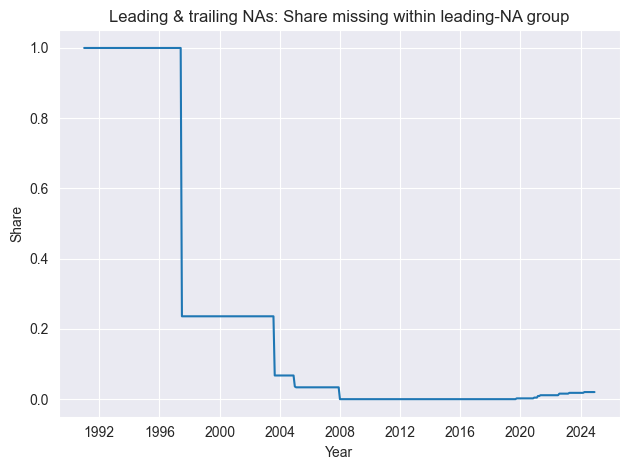

Gespeichert unter: ../grafiken/leading_trailing_NA_share_rel.png


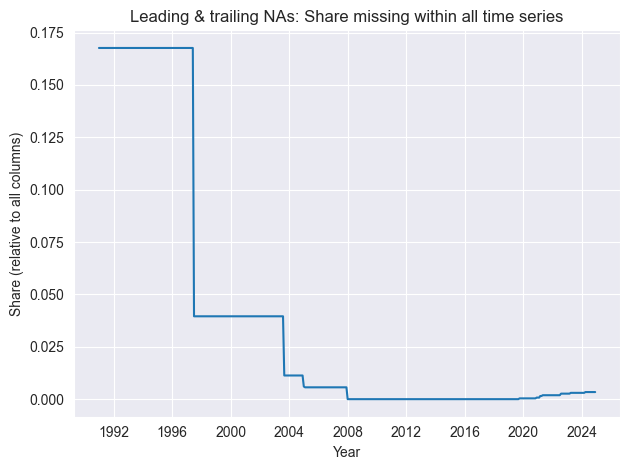

340 series start at 1997-07-01
75 series start at 2003-09-01
14 series start at 2005-01-01
1 series start at 2005-02-01
15 series start at 2008-01-01
436 series end at 2024-12-01
1 series end at 2024-03-01
1 series end at 2023-03-01
2 series end at 2022-07-01
1 series end at 2021-04-01
2 series end at 2021-02-01
1 series end at 2020-11-01
1 series end at 2019-09-01


In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sicherstellen, dass der Ausgabeordner existiert
os.makedirs("../grafiken", exist_ok=True)

lead_cols = [c for c, l in zip(X_full.columns, lead) if l]
if len(lead_cols) == 0:
    print("no columns with leading NAs")
else:
    fvi_lead, fvi_trail = {}, {}
    arr_index = np.arange(len(X_full.index))

    for c in lead_cols:
        a = X_full[c].isna().to_numpy()

        # leading NAs
        lv = 0
        for v in a:
            if v: lv += 1
            else: break
        fvi_lead[c] = lv

        # trailing NAs
        tv = 0
        for v in a[::-1]:
            if v: tv += 1
            else: break
        fvi_trail[c] = tv

    fvi_lead_vals = np.array(list(fvi_lead.values()))
    fvi_trail_vals = np.array(list(fvi_trail.values()))

    # absolute: share within the leading-NA group
    abs_curve = []
    for t in arr_index:
        still_missing = (fvi_lead_vals > t).sum() + (fvi_trail_vals > (len(arr_index)-1-t)).sum()
        abs_curve.append(still_missing / len(lead_cols))

    # relative: share relative to all columns
    rel_curve = []
    denom = X_full.shape[1]
    for t in arr_index:
        still_missing = (fvi_lead_vals > t).sum() + (fvi_trail_vals > (len(arr_index)-1-t)).sum()
        rel_curve.append(still_missing / denom)

    # --- Plot 1: absolute ---
    plt.figure()
    plt.plot(X_full.index, abs_curve)
    plt.xlabel("Year")
    plt.ylabel("Share")
    plt.title("Leading & trailing NAs: Share missing within leading-NA group")
    plt.tight_layout()

    save_path1 = os.path.join("../grafiken", "leading_trailing_NA_share_abs.png")
    plt.savefig(save_path1, dpi=300, bbox_inches='tight')
    print(f"Gespeichert unter: {save_path1}")

    plt.show()

    # --- Plot 2: relative ---
    plt.figure()
    plt.plot(X_full.index, rel_curve)
    plt.xlabel("Year")
    plt.ylabel("Share (relative to all columns)")
    plt.title("Leading & trailing NAs: Share missing within all time series")
    plt.tight_layout()

    save_path2 = os.path.join("../grafiken", "leading_trailing_NA_share_rel.png")
    plt.savefig(save_path2, dpi=300, bbox_inches='tight')
    print(f"Gespeichert unter: {save_path2}")

    plt.show()

# --- Jump Points ---
jump_counts_lead = pd.Series(fvi_lead_vals).value_counts().sort_index()
for pos, count in jump_counts_lead.items():
    print(f"{count} series start at {X_full.index[pos].date()}")

jump_counts_trail = pd.Series(fvi_trail_vals).value_counts().sort_index()
for pos, count in jump_counts_trail.items():
    print(f"{count} series end at {X_full.index[-pos-1].date()}")



Gespeichert unter: ../../grafiken/industrial_production.png


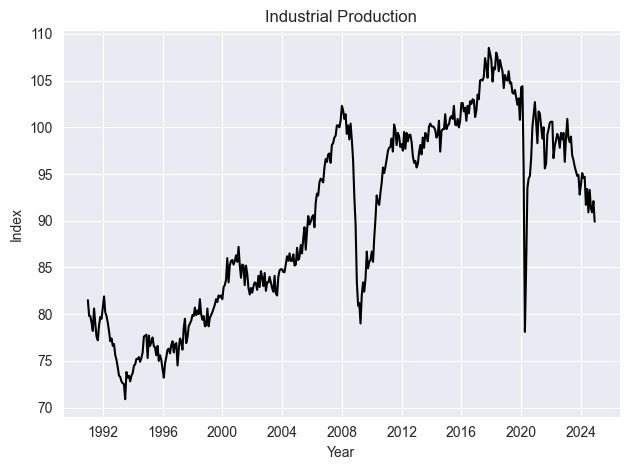

Gespeichert unter: ../../grafiken/ip_mom_change_running_mean.png


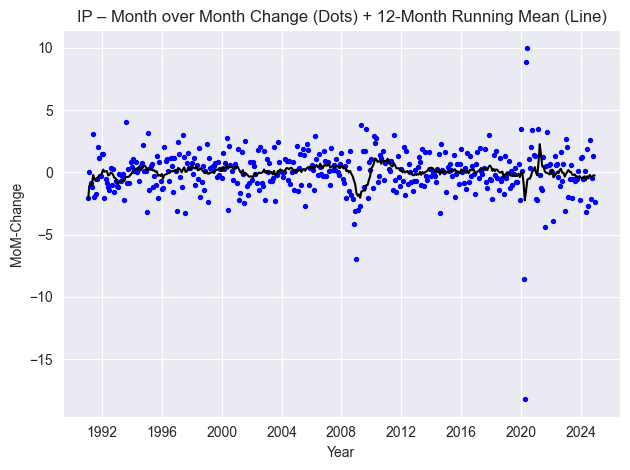

In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Sicherstellen, dass der Ausgabeordner existiert
os.makedirs("../../grafiken", exist_ok=True)

# --- Chart 1: Industrial Production ---
plt.figure()
plt.plot(y_level.index, y_level.values, color="black")
plt.title("Industrial Production")
plt.xlabel("Year")
plt.ylabel("Index")
plt.tight_layout()

save_path1 = os.path.join("../../grafiken", "industrial_production.png")
plt.savefig(save_path1, dpi=300, bbox_inches='tight')
print(f"Gespeichert unter: {save_path1}")

plt.show()

# --- Chart 2: Month-over-Month Change ---
rm = y_change.rolling(rm_window, min_periods=1).mean()
plt.figure()
plt.scatter(y_change.index, y_change.values, s=8, color="blue")
plt.plot(rm.index, rm.values, color="black")
plt.title("IP – Month over Month Change (Dots) + 12-Month Running Mean (Line)")
plt.xlabel("Year")
plt.ylabel("MoM-Change")
plt.tight_layout()

save_path2 = os.path.join("../../grafiken", "ip_mom_change_running_mean.png")
plt.savefig(save_path2, dpi=300, bbox_inches='tight')
print(f"Gespeichert unter: {save_path2}")

plt.show()



## Durchschnittliche Korrelation je Frage

Saved to: ../../grafiken/corr_distribution_per_question_boxplot.png


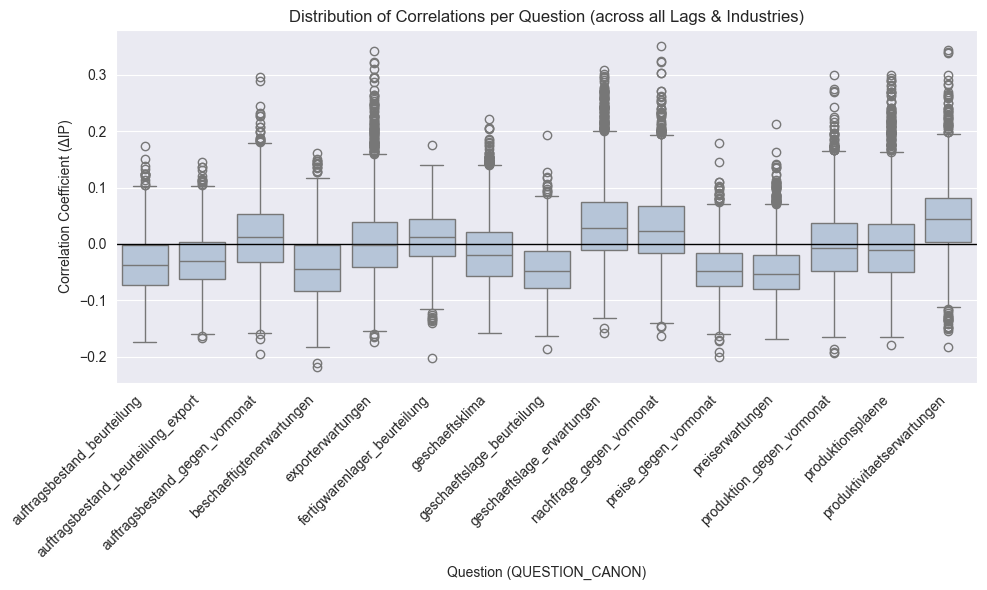

Saved to: ../../grafiken/corr_distribution_per_question_hist.png


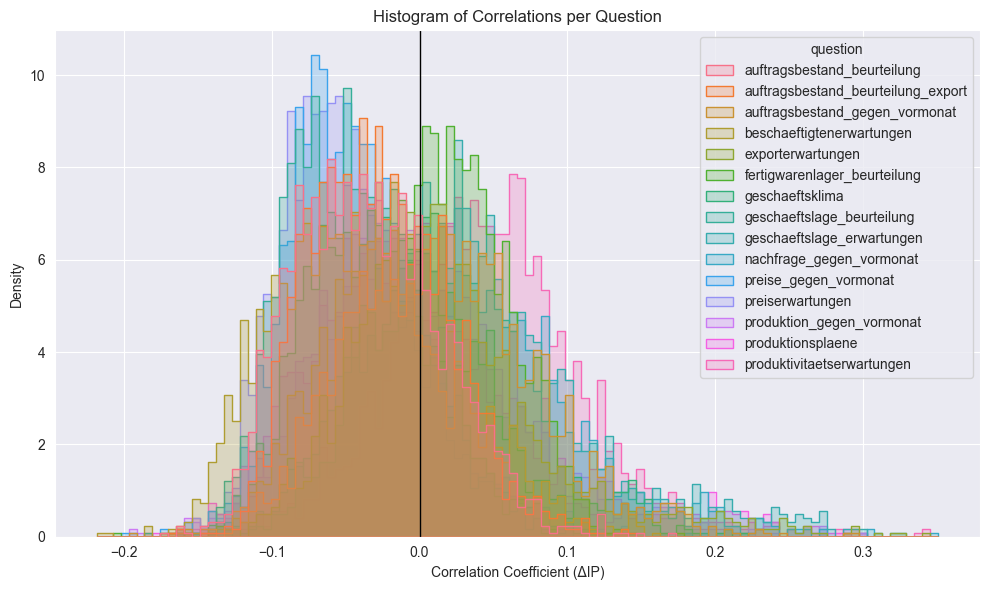

In [73]:
## Average Correlation per Question (Including Lag 0)
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# Ensure output directory exists
os.makedirs("../../grafiken", exist_ok=True)


def _slug(s: str) -> str:
    s = s.lower()
    s = (s.replace("ä", "ae").replace("ö", "oe").replace("ü", "ue").replace("ß", "ss")
         .replace(" ", "_").replace("-", "_"))
    s = re.sub(r"[^a-z0-9_\.]+", "", s)
    s = re.sub(r"\.+", ".", s)
    s = re.sub(r"_+", "_", s)
    return s.strip("._")


def split_norm(col: str):
    s = _slug(col)
    for q in QUESTION_CANON:
        if s.endswith("." + q):
            return s[:-(len(q) + 1)].strip("._"), q
        if s.endswith(q):
            before = s[:-(len(q))]
            if before.endswith("."):
                return before[:-1].strip("._"), q
    if "." in s:
        ind, qraw = s.rsplit(".", 1)
        q = re.sub(r"^(?:\d+\.|n\.?g\.?|ng\.?)+", "", qraw).strip("._")
        return ind.strip("._"), q
    return "", s


def corr_lag(x, y, lag, min_obs=24):
    xs = x.shift(lag)
    df = pd.concat([xs, y], axis=1).dropna()
    if df.shape[0] < min_obs:
        return np.nan
    return float(np.corrcoef(df.iloc[:, 0], df.iloc[:, 1])[0, 1])


# --- Calculation (Updated to include Lag 0) ---
lags = range(0, 13)  # <--- CHANGED: Starts at 0
cand = {}
for c in X_full.columns:
    _, qn = split_norm(c)
    if qn in QUESTION_CANON:
        cand.setdefault(qn, []).append(c)

mats = {}
for qn, cols in cand.items():
    if not cols:
        continue
    M = np.full((len(lags), len(cols)), np.nan)
    for j, col in enumerate(cols):
        x = X_full[col].astype(float)
        for i, lag in enumerate(lags):
            M[i, j] = corr_lag(x, y_change, lag)
    mats[qn] = pd.DataFrame(M, index=[str(l) for l in lags], columns=cols)

# --- Prepare Data for Plotting ---
records = []
for qn, M in mats.items():
    for lag in M.index:
        vals = M.loc[lag].dropna().astype(float)
        for v in vals:
            records.append({"question": qn, "corr": v})
df_corrs = pd.DataFrame(records)
if df_corrs.empty:
    raise ValueError("No correlations calculated.")

# --- Plot 1: Boxplot ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_corrs, x="question", y="corr", color="lightsteelblue")
plt.axhline(0, color="k", lw=1)
plt.title("Distribution of Correlations per Question (across all Lags & Industries)")  # <--- ENGLISH
plt.xlabel("Question (QUESTION_CANON)")  # <--- ENGLISH
plt.ylabel("Correlation Coefficient (ΔIP)")  # <--- ENGLISH
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

save_path1 = os.path.join("../../grafiken", "corr_distribution_per_question_boxplot.png")
plt.savefig(save_path1, dpi=300, bbox_inches='tight')
print(f"Saved to: {save_path1}")

plt.show()

# --- Plot 2: Histogram ---
plt.figure(figsize=(10, 6))
sns.histplot(data=df_corrs, x="corr", hue="question", element="step", stat="density", common_norm=False)
plt.axvline(0, color="k", lw=1)
plt.title("Histogram of Correlations per Question")  # <--- ENGLISH
plt.xlabel("Correlation Coefficient (ΔIP)")  # <--- ENGLISH
plt.ylabel("Density")  # <--- ENGLISH
plt.tight_layout()

save_path2 = os.path.join("../../grafiken", "corr_distribution_per_question_hist.png")
plt.savefig(save_path2, dpi=300, bbox_inches='tight')
print(f"Saved to: {save_path2}")
plt.show()


## Verteilung der höchsten abs Korrelation

Saved to: ../../grafiken/best_correlation_distribution.png


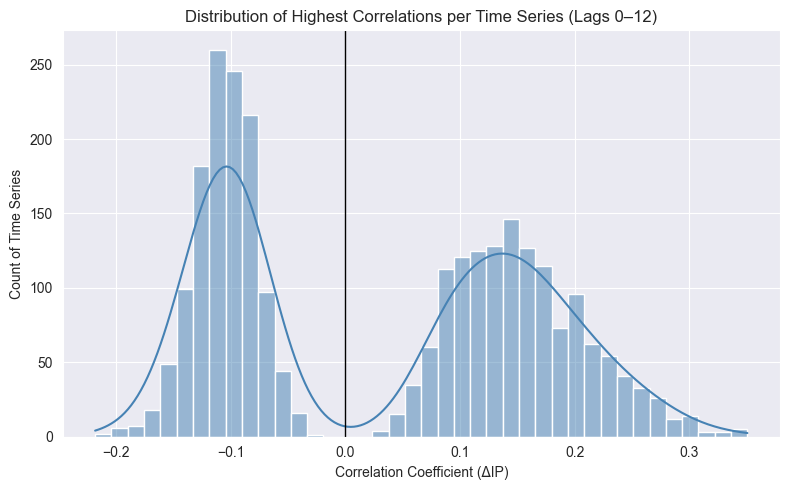

Saved to: ../../grafiken/best_abs_correlation_distribution.png


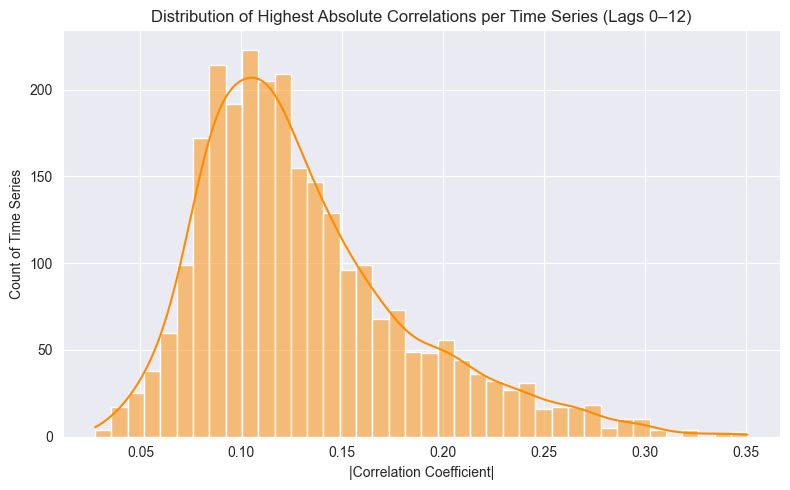

In [74]:
## Distribution of Highest Abs Correlation
import os
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

os.makedirs("../../grafiken", exist_ok=True)

# --- Calculation ---
corr_values = []
for qn, M in mats.items():
    for col in M.columns:
        series_corrs = M[col].astype(float)
        if series_corrs.isna().all():
            continue
        best_corr = series_corrs.loc[series_corrs.abs().idxmax()]
        corr_values.append(best_corr)

corr_values = pd.Series(corr_values, name="best_corr")

# --- Plot 1: Distribution of Highest Correlations ---
plt.figure(figsize=(8, 5))
sns.histplot(corr_values, bins=40, kde=True, color="steelblue")
plt.title("Distribution of Highest Correlations per Time Series (Lags 0–12)")  # <--- ENGLISH / CHANGED LAG RANGE
plt.xlabel("Correlation Coefficient (ΔIP)")  # <--- ENGLISH
plt.ylabel("Count of Time Series")  # <--- ENGLISH
plt.axvline(0, color="k", lw=1)
plt.tight_layout()

save_path1 = os.path.join("../../grafiken", "best_correlation_distribution.png")
plt.savefig(save_path1, dpi=300, bbox_inches='tight')
print(f"Saved to: {save_path1}")

plt.show()

# --- Plot 2: Distribution of Absolute Highest Correlations ---
plt.figure(figsize=(8, 5))
sns.histplot(corr_values.abs(), bins=40, kde=True, color="darkorange")
plt.title(
    "Distribution of Highest Absolute Correlations per Time Series (Lags 0–12)")  # <--- ENGLISH / CHANGED LAG RANGE
plt.xlabel("|Correlation Coefficient|")  # <--- ENGLISH
plt.ylabel("Count of Time Series")  # <--- ENGLISH
plt.tight_layout()

save_path2 = os.path.join("../../grafiken", "best_abs_correlation_distribution.png")
plt.savefig(save_path2, dpi=300, bbox_inches='tight')
print(f"Saved to: {save_path2}")

plt.show()

## Top-Features mit stärkster absoluter Korrelation (inkl. Lag)

In [75]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Sicherstellen, dass der Ausgabeordner existiert
os.makedirs("../../grafiken", exist_ok=True)

# Nur die Lags, die in den Top-N Features tatsächlich vorkommen
unique_lags = sorted(top_df["best_lag"].astype(int).unique())

# Farbpalette: Dark2 = kräftig & farbfehlsichtungsfreundlich
palette_colors = sns.color_palette("Dark2", n_colors=len(unique_lags))
lag_palette = {lag: palette_colors[i] for i, lag in enumerate(unique_lags)}

# --- Plot 1: Original-Korrelationen ---
plt.figure(figsize=(9, 7))
sns.barplot(
    data=top_df,
    y="feature", x="best_corr",
    hue="best_lag", hue_order=unique_lags,
    dodge=False, palette=lag_palette
)
plt.axvline(0, color="k", lw=1)
plt.title(f"Top {TOP_N} Features mit stärkster Korrelation (über alle Lags)")
plt.xlabel("Korrelationskoeffizient (ΔIP)")
plt.ylabel("Feature")
plt.legend(title="Lag", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

save_path1 = os.path.join("../../grafiken", f"top_features_corr_{TOP_N}.png")
plt.savefig(save_path1, dpi=300, bbox_inches='tight')
print(f"Gespeichert unter: {save_path1}")
plt.show()

# --- Plot 2: Absolute Korrelationen ---
top_df_abs = top_df.assign(best_corr=lambda d: d["best_corr"].abs())

plt.figure(figsize=(9, 7))
sns.barplot(
    data=top_df_abs,
    y="feature", x="best_corr",
    hue="best_lag", hue_order=unique_lags,
    dodge=False, palette=lag_palette
)
plt.title(f"Top {TOP_N} Features mit stärkster *absoluter* Korrelation (über alle Lags)")
plt.xlabel("|Korrelationskoeffizient| (ΔIP)")
plt.ylabel("Feature")
plt.legend(title="Lag", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

save_path2 = os.path.join("../../grafiken", f"top_features_corr_abs_{TOP_N}.png")
plt.savefig(save_path2, dpi=300, bbox_inches='tight')
print(f"Gespeichert unter: {save_path2}")
plt.show()



NameError: name 'top_df' is not defined

## Verteilung der Korrelationen je Lag

NA-free features: 2161 / 2654
Saved to: ../../grafiken/correlation_distribution_per_lag_nona_features.png


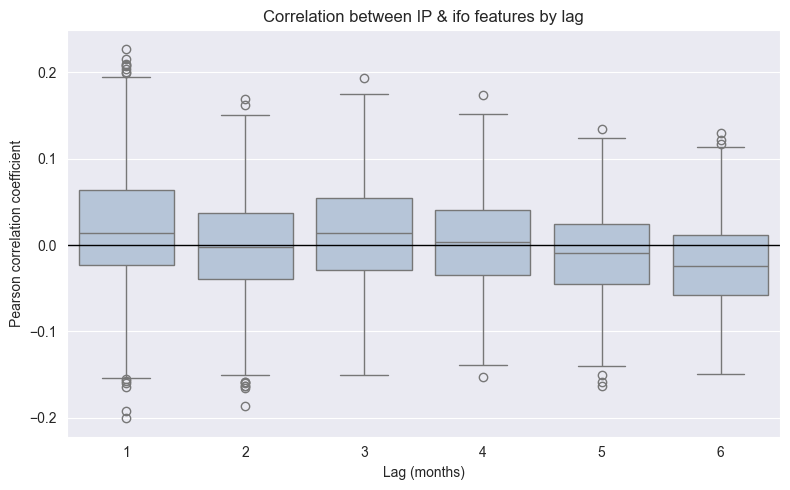

/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_15013/1561828162.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lag_summary = df_abs.groupby("lag")["abs_corr"].median().reset_index()


Saved to: ../../grafiken/median_abs_correlation_per_lag_nona_features.png


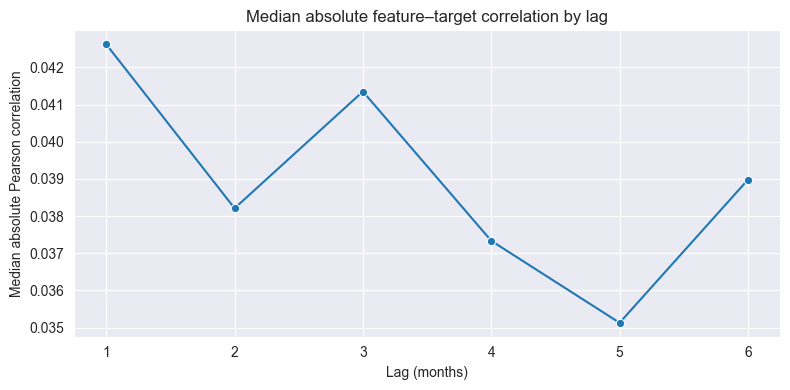

In [85]:
import os
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

os.makedirs("../../grafiken", exist_ok=True)

# 1) Features without any NA over the full index of X_full
complete_feats = X_full.columns[X_full.notna().all(axis=0)]
print(f"NA-free features: {len(complete_feats)} / {X_full.shape[1]}")

# 2) Filter mats to NA-free features
mats_complete = {}
complete_set = set(complete_feats)
for qn, M in mats.items():
    keep_cols = [c for c in M.columns if c in complete_set]
    if keep_cols:
        mats_complete[qn] = M[keep_cols]

# 3) Long-format (lags 1..6)
records = []
for qn, M in mats_complete.items():
    for lag in M.index:
        lag_int = int(lag)
        if not (1 <= lag_int <= 6):
            continue
        vals = M.loc[lag].dropna().astype(float).values
        records.extend([{"lag": lag_int, "corr": v} for v in vals])

df_corrs = pd.DataFrame(records)
if df_corrs.empty:
    raise ValueError("No correlations left — likely no completely NA-free feature series in mats.")

df_corrs["lag"] = pd.Categorical(df_corrs["lag"], categories=list(range(1, 7)), ordered=True)

# --- Plot 1: Correlation distribution by lag ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_corrs, x="lag", y="corr", color="lightsteelblue")
plt.axhline(0, color="k", lw=1)

plt.title("Correlation between IP & ifo features by lag")
plt.xlabel("Lag (months)")
plt.ylabel("Pearson correlation coefficient")
plt.tight_layout()

save_path1 = os.path.join("../../grafiken", "correlation_distribution_per_lag_nona_features.png")
plt.savefig(save_path1, dpi=300, bbox_inches="tight")
print(f"Saved to: {save_path1}")
plt.show()

# --- Plot 2: Median absolute correlation by lag ---
df_abs = df_corrs.assign(abs_corr=lambda d: d["corr"].abs())
lag_summary = df_abs.groupby("lag")["abs_corr"].median().reset_index()

plt.figure(figsize=(8, 4))
sns.lineplot(data=lag_summary, x="lag", y="abs_corr", marker="o")

plt.title("Median absolute feature–target correlation by lag")
plt.xlabel("Lag (months)")
plt.ylabel("Median absolute Pearson correlation")
plt.tight_layout()

save_path2 = os.path.join("../../grafiken", "median_abs_correlation_per_lag_nona_features.png")
plt.savefig(save_path2, dpi=300, bbox_inches="tight")
print(f"Saved to: {save_path2}")
plt.show()



In [58]:
# --- Sanity check + summary ONLY for the boxplot data (lags 1–6) ---
import numpy as np

# df_corrs is your boxplot dataframe (already filtered to lags 1-6)
corr = df_corrs["corr"].astype(float).to_numpy()

max_corr = np.nanmax(corr)
min_corr = np.nanmin(corr)
max_abs_corr = np.nanmax(np.abs(corr))
pct_abs_lt_01 = 100 * np.mean(np.abs(corr) < 0.1)

print("Summary for BOXPlot data only (lags 1–6)")
print(f"N = {len(corr):,}")
print(f"Max corr            = {max_corr:.4f}")
print(f"Min corr            = {min_corr:.4f}")
print(f"Max |corr|          = {max_abs_corr:.4f}")
print(f"% with |corr| < 0.1 = {pct_abs_lt_01:.2f}%")

# Optional: show where the max occurs (helps debugging)
i_max = int(np.nanargmax(corr))
i_abs = int(np.nanargmax(np.abs(corr)))
print(f"Max corr occurs at lag={df_corrs.iloc[i_max]['lag']}, corr={df_corrs.iloc[i_max]['corr']:.4f}")
print(f"Max |corr| occurs at lag={df_corrs.iloc[i_abs]['lag']}, corr={df_corrs.iloc[i_abs]['corr']:.4f}")

# If you want a hard assertion that matches the visual impression:
print(f"Any corr > 0.2? {bool(np.any(corr > 0.2))}")
print(f"Any |corr| > 0.2? {bool(np.any(np.abs(corr) > 0.2))}")

Summary for BOXPlot data only (lags 1–6)
N = 15,924
Max corr            = 0.2270
Min corr            = -0.2183
Max |corr|          = 0.2270
% with |corr| < 0.1 = 92.66%
Max corr occurs at lag=1.0, corr=0.2270
Max |corr| occurs at lag=1.0, corr=0.2270
Any corr > 0.2? True
Any |corr| > 0.2? True


In [ ]:
# CHUNK 6 — Heatmaps je Frage: corr(Branche.Frage[t-lag], ΔIP[t]), Lags 1..12
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import TwoSlopeNorm

# fixe Branchenliste (Reihenfolge bleibt)
target_industries = [
    "Verarbeitendes_Gewerbe",
    "Verarbeitendes_Gewerbe_(ohne_Ernährungsgewerbe)",
    "Herstellung_von_Vorleistungsgütern",
    "Herstellung_von_Investitionsgütern",
    "Herstellung_von_Konsumgütern_(Ge-_und_Verbrauchsgüter)",
    "Herstellung_von_Gebrauchsgütern",
    "Herstellung_von_Verbrauchsgütern",
    "Herstellung_von_Konsumgütern_(ohne_Ernährungsgewerbe)",
    "Herstellung_von_Verbrauchsgütern_(ohne_Ernährungsgewerbe)",
    "Ernährungsgewerbe_und_Tabakverarbeitung",
    "Herstellung_von_Nahrungs-_und_Futtermitteln",
    "Schlachten_und_Fleischverarbeitung",
]

# Fragetypen (normalisiert)
QUESTION_CANON = [
    "auftragsbestand_beurteilung",
    "auftragsbestand_beurteilung_export",
    "auftragsbestand_gegen_vormonat",
    "beschaeftigtenerwartungen",
    "exporterwartungen",
    "fertigwarenlager_beurteilung",
    "geschaeftsklima",
    "geschaeftslage_beurteilung",
    "geschaeftslage_erwartungen",
    "nachfrage_gegen_vormonat",
    "preise_gegen_vormonat",
    "preiserwartungen",
    "produktion_gegen_vormonat",
    "produktionsplaene",
    "produktivitaetserwartungen",
]

def _slug(s: str) -> str:
    s = s.lower()
    s = (s.replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss")
           .replace(" ", "_").replace("-", "_"))
    s = re.sub(r"[^a-z0-9_\.]+", "", s)
    s = re.sub(r"\.+", ".", s)
    s = re.sub(r"_+", "_", s)
    return s.strip("._")

def split_norm(col: str):
    s = _slug(col)
    for q in QUESTION_CANON:
        if s.endswith("." + q):
            return s[:-(len(q)+1)].strip("._"), q
        if s.endswith(q):
            before = s[:-(len(q))]
            if before.endswith("."): return before[:-1].strip("._"), q
    if "." in s:
        ind, qraw = s.rsplit(".", 1)
        q = re.sub(r"^(?:\d+\.|n\.?g\.?|ng\.?)+", "", qraw).strip("._")
        return ind.strip("._"), q
    return "", s

present_inds = [ind for ind in target_industries if any(c.startswith(ind + ".") for c in X_full.columns)]
if not present_inds:
    raise ValueError("Keine der Zielbranchen in X_full gefunden.")

# (industry, question_norm) -> Spaltenliste
cand = {}
for c in X_full.columns:
    raw_ind = c.split(".", 1)[0] if "." in c else ""
    if raw_ind not in present_inds: continue
    ind, qn = split_norm(c)
    if (not ind) or (not qn) or (qn not in QUESTION_CANON): continue
    cand.setdefault((raw_ind, qn), []).append(c)

qnorms = [q for q in QUESTION_CANON if any((ind, q) in cand for ind in present_inds)]

def pick_best_series(ind, qn):
    cols = cand.get((ind, qn), [])
    if not cols: return None
    def score(col):
        s = X_full[col]
        miss = s.isna().mean()
        a = s.isna().to_numpy()
        lead = 0
        for v in a:
            if v: lead += 1
            else: break
        return (miss, lead)
    best = min(cols, key=score)
    return X_full[best].astype(float)

def corr_lag(x, y, lag, min_obs=24):
    xs = x.shift(lag)
    df = pd.concat([xs, y], axis=1).dropna()
    if df.shape[0] < min_obs: return np.nan
    return float(np.corrcoef(df.iloc[:,0], df.iloc[:,1])[0,1])

# Matrices je Frage
lags = list(range(1, 13))
mats = {}
for qn in qnorms:
    M = np.full((len(lags), len(present_inds)), np.nan)
    for j, ind in enumerate(present_inds):
        x = pick_best_series(ind, qn)
        if x is None: continue
        for i, lag in enumerate(lags):
            M[i, j] = corr_lag(x, y_change, lag)
    mats[qn] = pd.DataFrame(M, index=[str(l) for l in lags], columns=present_inds)

# Plot — divergente Palette (ColorBrewer RdBu_r), symm. Dynamik um 0
save_pdf = None   # "../reports/corr_heatmaps_selected_industries.pdf"
fig_w, fig_h = 6, 10
cbar_label = "Korrelationskoeffizient"
cmap_name = "RdBu_r"  # Alternativen: "RdYlBu_r", "PuOr", "BrBG"

pdf = PdfPages(save_pdf) if save_pdf else None
try:
    for qn, M in mats.items():
        data = M.to_numpy(dtype=float)
        vmax_sym = np.nanpercentile(np.abs(data), 97.5)  # robust saturieren
        if not np.isfinite(vmax_sym) or vmax_sym <= 0:
            vmax_sym = 1.0
        norm = TwoSlopeNorm(vmin=-vmax_sym, vcenter=0.0, vmax=vmax_sym)

        fig = plt.figure(figsize=(fig_w, fig_h))
        im = plt.imshow(np.ma.masked_invalid(data), aspect="auto", origin="upper",
                        cmap=cmap_name, norm=norm)
        cbar = plt.colorbar(im)
        cbar.set_label(cbar_label)
        # optionale feste Ticks
        ticks = [-vmax_sym, -0.5*vmax_sym, 0.0, 0.5*vmax_sym, vmax_sym]
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([f"{t:.2f}" for t in ticks])

        plt.yticks(range(M.shape[0]), M.index, fontsize=10)
        plt.xticks(range(M.shape[1]), M.columns, rotation=90, fontsize=8)
        plt.ylabel("Lag")
        plt.title(f"Korrelation: {qn}  vs  ΔIP")

        plt.gcf().subplots_adjust(bottom=0.38, top=0.92)
        plt.tight_layout()

        if pdf: pdf.savefig(fig); plt.close(fig)
        else: plt.show()
finally:
    if pdf: pdf.close()



/var/folders/jl/__x0ybfj19qbrwgn16qjksvh0000gn/T/ipykernel_15013/1550267197.py:37: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout(); plt.show()
/Users/jonasschernich/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


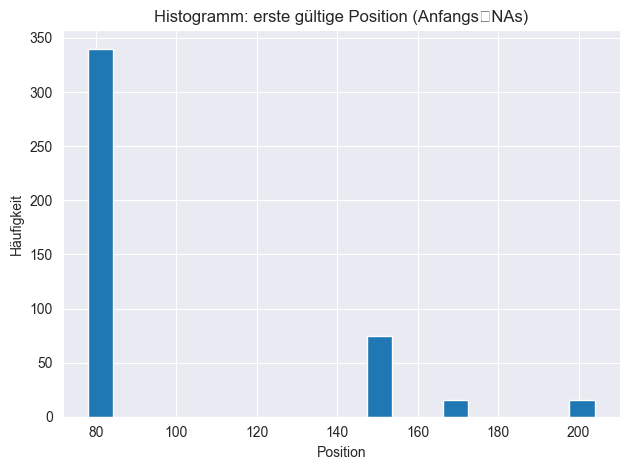

In [20]:

# CHUNK 9 — Zusatz 2: Verteilung der ersten gültigen Monate (nur Spalten mit Anfangs‑NA)
import numpy as np, matplotlib.pyplot as plt

def missing_pattern_flags(s: pd.Series):
    a = s.isna().to_numpy()
    if not a.any():
        return False, False, False, False  # has, lead, mid, trail
    lead = 0
    for v in a:
        if v: lead += 1
        else: break
    trail = 0
    for v in a[::-1]:
        if v: trail += 1
        else: break
    has = True
    if lead + trail >= len(a):
        mid = False
    else:
        mid = a[lead:len(a)-trail].any()
    return has, (lead>0), mid, (trail>0)

lead_cols = [c for c in X_full.columns if missing_pattern_flags(X_full[c])[1]]
if lead_cols:
    first_valid_pos = []
    for c in lead_cols:
        a = X_full[c].isna().to_numpy()
        lv = 0
        for v in a:
            if v: lv += 1
            else: break
        first_valid_pos.append(lv)
    plt.figure()
    plt.hist(first_valid_pos, bins=20)
    plt.title("Histogramm: erste gültige Position (Anfangs‑NAs)")
    plt.xlabel("Position"); plt.ylabel("Häufigkeit")
    plt.tight_layout(); plt.show()
else:
    print("keine Spalten mit Anfangs‑NAs")


Gespeichert unter: ../../grafiken/autocorrelation_delta_ip_1-6.png


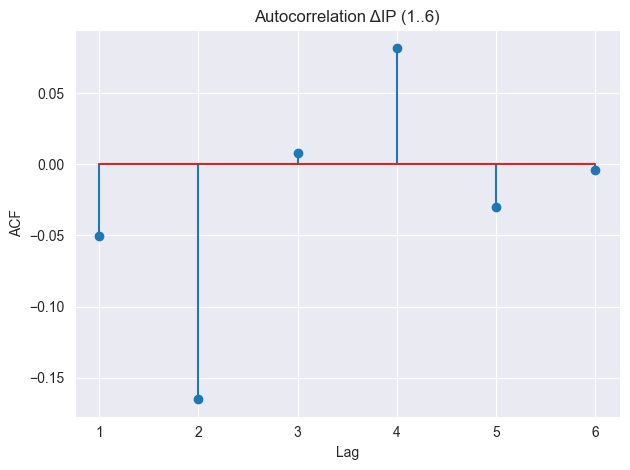

Gespeichert unter: ../../grafiken/autocorrelation_delta_ip_confband_1-6.png


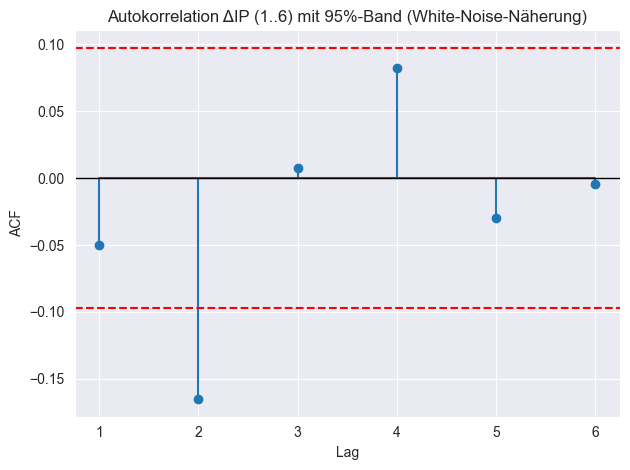


Ljung–Box-Test (H0: keine Autokorrelation bis Lag h):
     lb_stat  lb_pvalue
1   1.021358   0.312197
2  12.132385   0.002320
3  12.156386   0.006866
4  14.889817   0.004935
5  15.245304   0.009364
6  15.252538   0.018381


In [25]:
import os
import numpy as np, matplotlib.pyplot as plt
import pandas as pd

from statsmodels.stats.diagnostic import acorr_ljungbox  # NEU

# Sicherstellen, dass der Ausgabeordner existiert
os.makedirs("../../grafiken", exist_ok=True)

# Beispiel: wir nehmen die Spalte "IP_change" als y_change
y_change = df["IP_change"].dropna()

lags = range(1, 7)
vals = []
for k in lags:
    a = pd.concat([y_change.shift(k), y_change], axis=1).dropna()
    if len(a) < 3:
        vals.append(np.nan)
    else:
        vals.append(float(np.corrcoef(a.iloc[:, 0], a.iloc[:, 1])[0, 1]))

# --- Plot 1: Autokorrelation ΔIP (1..6) ---
plt.figure()
plt.stem(list(lags), vals)
plt.title("Autocorrelation ΔIP (1..6)")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()

save_path1 = os.path.join("../../grafiken", "autocorrelation_delta_ip_1-6.png")
plt.savefig(save_path1, dpi=300, bbox_inches="tight")
print(f"Gespeichert unter: {save_path1}")
plt.show()

# --- Plot 2: Autokorrelation mit Konfidenzband ---
n = len(y_change)
conf = 1.96 / np.sqrt(n)  # 95%-Daumenregel unter White Noise

plt.figure()
plt.stem(list(lags), vals)
plt.axhline(y=0, color="black", linewidth=1)
plt.axhline(y=conf, color="red", linestyle="--")
plt.axhline(y=-conf, color="red", linestyle="--")
plt.title("Autokorrelation ΔIP (1..6) mit 95%-Band (White-Noise-Näherung)")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.tight_layout()

save_path2 = os.path.join("../../grafiken", "autocorrelation_delta_ip_confband_1-6.png")
plt.savefig(save_path2, dpi=300, bbox_inches="tight")
print(f"Gespeichert unter: {save_path2}")
plt.show()

# --- Ljung–Box-Test (gemeinsam über mehrere Lags) ---
# H0: keine Autokorrelation bis einschließlich Lag h
lb = acorr_ljungbox(y_change, lags=list(lags), return_df=True)

print("\nLjung–Box-Test (H0: keine Autokorrelation bis Lag h):")
print(lb)  # enthält typischerweise: lb_stat, lb_pvalue
